## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [19]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [20]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [21]:
import findspark
findspark.init()

from pyspark import SparkContext
sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [22]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [23]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
# file_index='BBBSBBBB'
file_index='SSSSSSBB'
meas='TOBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
1271
+-------------------+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|            coeff_1|           coeff_2|           coeff_3|           coeff_4|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|              res_4|           res_mean|    station|  total_var|undefs|              vector|  year|
+-------------------+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|-1073.8061998945723| 425.3767238176554| 42.68208887773061|3.

In [47]:
#extract longitude and latitude for each station
# feature='coeff_1'
feature='coeff_1,coeff_2,coeff_3,coeff_4'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1,coeff_2,coeff_3,coeff_4 FROM weather
+-----------+--------+---------+---------+-------------------+------------------+-------------------+------------------+
|    station|latitude|longitude|elevation|            coeff_1|           coeff_2|            coeff_3|           coeff_4|
+-----------+--------+---------+---------+-------------------+------------------+-------------------+------------------+
|USC00040924| 33.6131|-114.5972|     81.7|-1073.8061998945723| 425.3767238176554|  42.68208887773061|3.3903781535373803|
|USC00025467| 33.4114|-111.8183|    376.4|  867.6905688679807|-221.5527912895148| -93.93643596313063|   154.72513773382|
|USC00029464| 33.7478|-112.5983|    509.0|  1144.772608463281|1.0933318043838796|  58.94502312825961| -80.6172205841649|
|USC00025467| 33.4114|-111.8183|    376.4| 1012.4266903252479| 69.01180839241843|-55.144310401250365| 6.187558886544997|
+-----------+--------+---------+---------+-------------------+-

In [48]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", "coeff_1": "mean","coeff_2": "mean","coeff_3": "mean","coeff_4": "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,avg(coeff_4),avg(coeff_1),avg(coeff_2),avg(coeff_3),count(station)
40,USC00020060,33.9433,-113.1875,659.9,-35.905451,450.358303,11.023181,-1.288595,34
0,USC00020104,33.5167,-112.1167,348.1,-2.759195,-258.625111,-133.967689,39.615690,26


In [50]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max
print _min
print _max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

KeyError: 'avg(coeff_1,coeff_2,coeff_3,coeff_4)'

## Map

In [27]:
min_lat,max_lat,min_long,max_long = box = (33.3369, 34.1158, -116.5833, -111.7432)


In [37]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

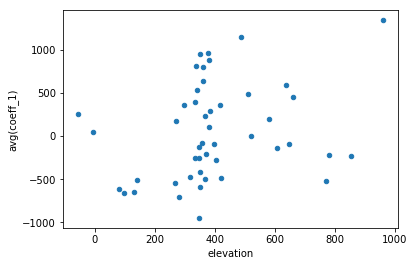

In [34]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [ ]:
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

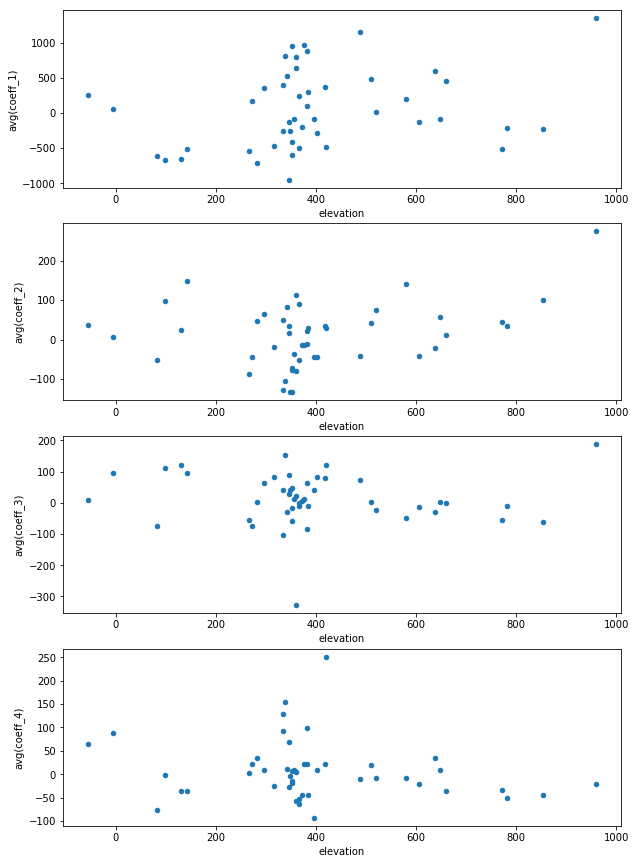

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=False,figsize=(10,15))
# pdf.plot.scatter(x='elevation',y='avg(coeff_3)');
pdf.plot(x='elevation',y='avg(coeff_1)', kind="scatter", ax=ax1)
pdf.plot(x='elevation',y='avg(coeff_2)', kind="scatter", ax=ax2)
pdf.plot(x='elevation',y='avg(coeff_3)', kind="scatter", ax=ax3)
pdf.plot(x='elevation',y='avg(coeff_4)', kind="scatter", ax=ax4)

# fig.savefig("hw5_figures/coeff_elevation.png")

In [31]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']